## Moving Average

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [96]:
def load_data(ticker, start, end):
    data = yf.download(ticker, start=start, end=end)
    data['Returns'] = data['Adj Close'].pct_change()
    return data

# Moving Average Strategy
def moving_average_strategy(data, short_window, long_window):
    data['Short_MA'] = data['Adj Close'].rolling(window=short_window, min_periods=1).mean()
    data['Long_MA'] = data['Adj Close'].rolling(window=long_window, min_periods=1).mean()
    data['Signal'] = 0

    # Generate signal only on the crossover day
    crossover_indices = np.where((data['Short_MA'].shift(1) <= data['Long_MA'].shift(1)) & (data['Short_MA'] > data['Long_MA']))
    data.loc[data.index[crossover_indices], 'Signal'] = 1

    data['Position'] = data['Signal'].shift()
    return data

def prepare_meta_labels(data, threshold=0.02):
    data['Meta_Label'] = np.nan
    signal_indices = data[data['Signal'] == 1].index

    for i in range(len(signal_indices)):
        if i + 1 < len(signal_indices):
            next_day_index = signal_indices[i + 1]
            data.loc[signal_indices[i], 'Meta_Label'] = 1 if data.loc[next_day_index, 'Returns'] > threshold else 0

    return data.dropna(subset=['Meta_Label'])

In [116]:
ticker = 'AAPL'
start_date = '2000-01-01'
end_date = pd.to_datetime('today')
short_window = 5
long_window = 20

data = load_data(ticker, start_date, end_date)
data = moving_average_strategy(data, short_window, long_window)

[*********************100%%**********************]  1 of 1 completed


In [117]:
data

,Open,High,Low,Close,Adj Close,Volume,Returns,Short_MA,Long_MA,Signal,Position
Date,,,,,,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.844981,535796800,NaN,0.844981,0.844981,0,NaN
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.773741,512377600,-0.084310,0.809361,0.809361,0,0.0
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.785063,778321600,0.014633,0.801261,0.801261,0,0.0
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.717125,767972800,-0.086538,0.780227,0.780227,0,0.0
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.751094,460734400,0.047369,0.774401,0.774401,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-24,188.820007,190.580002,188.039993,189.979996,189.979996,36294600,0.016588,190.229999,183.806573,0,0.0
2024-05-28,191.509995,193.000000,189.100006,189.990005,189.990005,52280100,0.000053,190.020001,184.642824,0,0.0
2024-05-29,189.610001,192.250000,189.509995,190.289993,190.289993,53068000,0.001579,189.607999,185.652359,0,0.0


In [118]:
features = ['^FVX','^TYX','^VIX','JPY=X','^GSPC','GC=F']
exog = yf.download(
    features,
    start = start_date,
    end = end_date
)['Adj Close']

[*********************100%%**********************]  6 of 6 completed


In [119]:
exog[['^FVX','^TYX','JPY=X','^GSPC','GC=F']] = exog[['^FVX','^TYX','JPY=X','^GSPC','GC=F']].pct_change()
exog['^VIX'] = exog['^VIX'] * 0.01

/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_31071/365485493.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  exog[['^FVX','^TYX','JPY=X','^GSPC','GC=F']] = exog[['^FVX','^TYX','JPY=X','^GSPC','GC=F']].pct_change()


In [120]:
from ta.volume import money_flow_index, ease_of_movement
from ta.volatility import average_true_range, ulcer_index
from ta.trend import adx, trix
from ta.momentum import rsi, stoch
def psycological_index(data, window = 12):
    up_days = data['Close'].diff() > 0
    sentiment = up_days.rolling(window = window).sum() / window
    return sentiment

data['money_flow_index'] = money_flow_index(
    high = data['High'],
    low = data['Low'],
    close = data['Close'],
    volume = data['Volume'],
    window = 14
) * 0.01 # normalizing
data['ease_of_movement'] = ease_of_movement(
    high = data['High'],
    low = data['Low'],
    volume = data['Volume'],
    window = 14
) * 0.01
data['average_true_range'] = average_true_range(
    high = data['High'],
    low = data['Low'],
    close = data['Close'],
    window = 14
).pct_change()
data['ulcer_index'] = ulcer_index(
    close = data['Close'],
    window = 14
) * 0.01
data['adx'] = adx(
    high = data['High'],
    low = data['Low'],
    close = data['Close'],
    window = 14
) * 0.01
data['trix'] = trix(
    close = data['Close'],
    window = 14
) * 0.01
data['rsi'] = rsi(
    close = data['Close'],
    window = 14
) * 0.01
data['stoch'] = stoch(
    high = data['High'],
    low = data['Low'],
    close = data['Close'],
    window = 14
) * 0.01
data['psycological_index'] = psycological_index(
    data, window = 14
)

In [121]:
data['ret'] = data['Close'].pct_change()
data['std'] = data['Close'].pct_change().rolling(window = 20).std()
data['skew'] = data['Close'].pct_change().rolling(window = 20).skew()
data['kurt'] = data['Close'].pct_change().rolling(window = 20).kurt()

In [122]:
data = pd.concat(
    [data, exog], axis = 1
)

In [123]:
data.dropna(inplace = True)

In [135]:
data = prepare_meta_labels(data[data['Signal'] == 1], threshold = 0.01)

In [137]:
X = data.drop(['Open','High','Low','Close','Adj Close','Volume','Short_MA','Long_MA','Signal','Position','Returns','Meta_Label'], axis = 1)
y = data['Meta_Label']

In [138]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train = X[:'2019']
X_test = X['2020':]
y_train = y[:'2019']
y_test = y['2020':]

In [139]:
meta_model = RandomForestClassifier(
    n_estimators = 1000, 
    criterion = 'entropy',
    random_state = 42,
    max_features = 3,
    oob_score = True
)
meta_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features=3, n_estimators=1000,
                       oob_score=True, random_state=42)

In [140]:
y_pred = meta_model.predict(X_test)

In [143]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.50      0.45      0.48        11
         1.0       0.60      0.64      0.62        14

    accuracy                           0.56        25
   macro avg       0.55      0.55      0.55        25
weighted avg       0.56      0.56      0.56        25



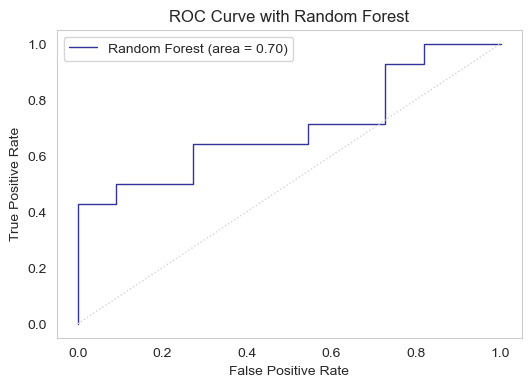

In [145]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
y_prob = meta_model.predict_proba(X_test)[:, 1]
y_pred = meta_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = 'Random Forest (area = {:.2f})'.format(roc_auc), color = 'navy', alpha = 0.8, lw = 1)
plt.plot([0, 1], [0, 1], color = 'lightgray', ls = ':', lw = 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Random Forest')
plt.grid(False)
plt.legend()
plt.show()

<Axes: xlabel='Date'>

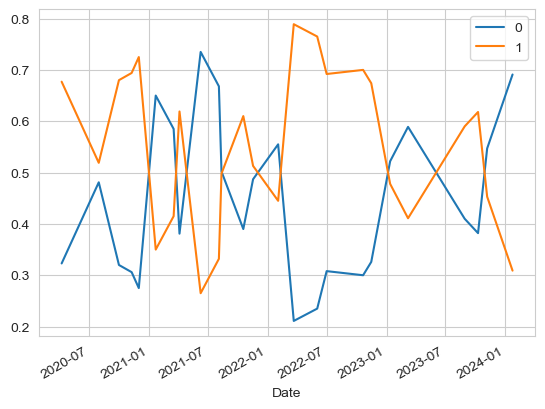

In [147]:
pd.DataFrame(meta_model.predict_proba(X_test), index = X_test.index).plot()